# Imports

In [59]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from models import DeGrootThresholdModel
from utils import add_random_edges, assign_edge_weights
from utils.graph_utils import create_sbm_graph, create_influencer_graph
from visualization.plot_utils import plot_network, plot_posting_heatmap
from main import run_experiment


# Create the graph

In [20]:
# Create graph with custom edge counts
buckets = ['High', 'Medium', 'Low', 'Very High', 'Very Low', 'Moderate', 'Extreme']
counts = [1, 6, 5, 17, 72, 318, 581]
edges = [100, 50, 25, 15, 8, 4, 1]

G = create_influencer_graph(
    n_nodes=1000,
    view_buckets=buckets,
    bucket_counts=counts,
    bucket_edges=edges
)

## Connect to DeGroot + Checks

Initial opinion distribution:
  Positive opinions: 41.00%
  Negative opinions: 30.00%
  Neutral opinions: 29.00%
  Positive-to-negative ratio: 1.37
  Initial proportion of opinions on positive side: 57.75%


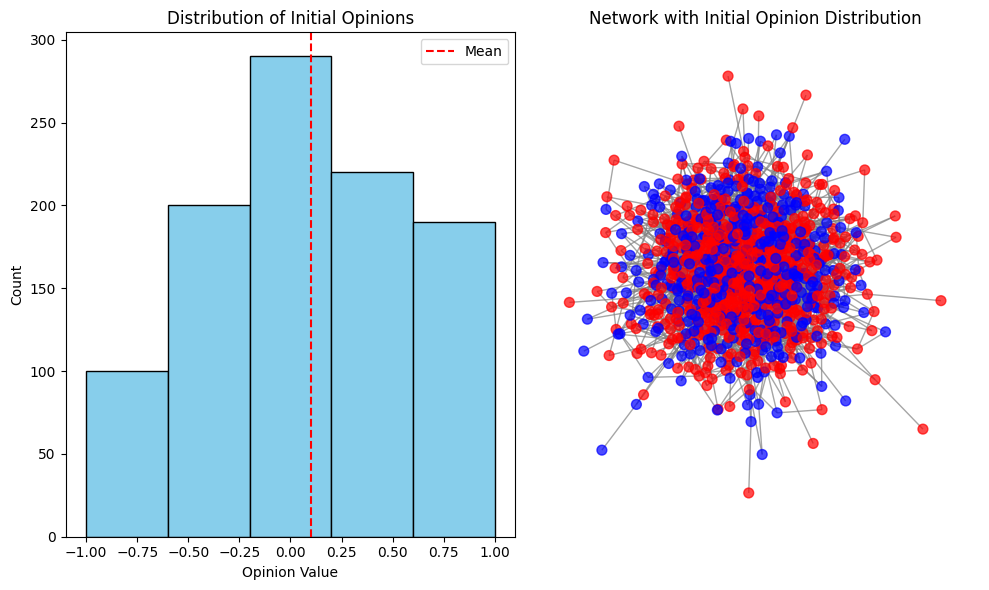

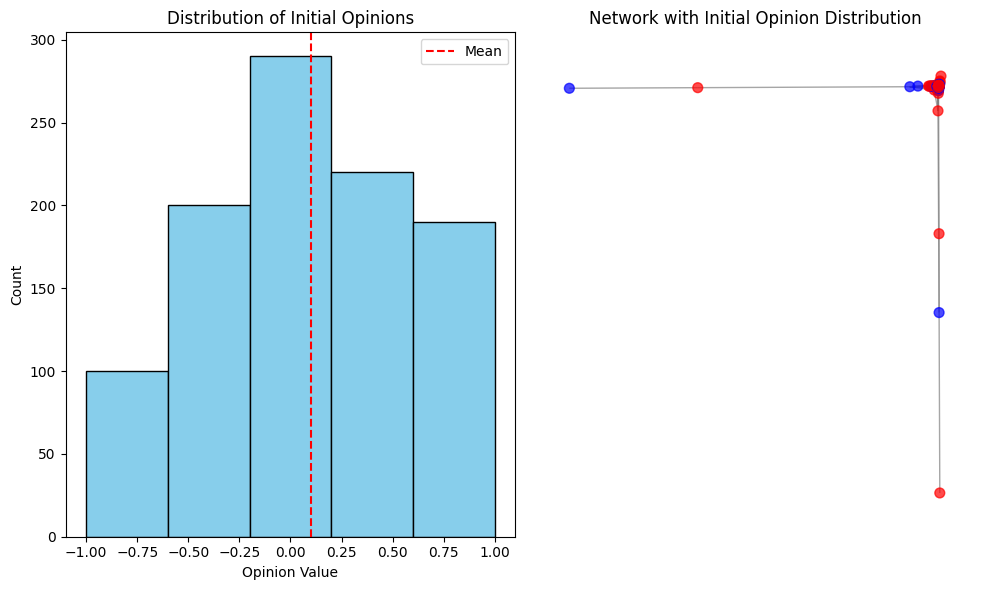

Is the graph connected? True
Are there self loops? False


In [21]:
model = DeGrootThresholdModel(G, local_agreement_threshold=0.6)

ispal_op = [-1, -.5, 0, .5, 1]
ispal_prop = [.1, .2, .29, .22, .19] # target 90/10

model.initialize_opinions_manual(
    initial_opinions=ispal_op,
    proportions=ispal_prop
)

model.visualize_distribution(layout='spring')
model.visualize_distribution(layout='spectral')

# Check if graph is connected - needs to be connected for DeGroot model
is_connected = nx.is_connected(G)
print(f"Is the graph connected? {is_connected}")

if not is_connected:
    # Get number of components
    components = list(nx.connected_components(G))
    print(f"Number of connected components: {len(components)}")
    print(f"Sizes of components: {[len(c) for c in components]}")

# Check for self loops
has_self_loops = nx.number_of_selfloops(G)
print("Are there self loops?", has_self_loops > 0)

## Run the model

Initial opinion distribution:
  Positive opinions: 41.00%
  Negative opinions: 30.00%
  Neutral opinions: 29.00%
  Positive-to-negative ratio: 1.37
  Initial proportion of opinions on positive side: 57.75%


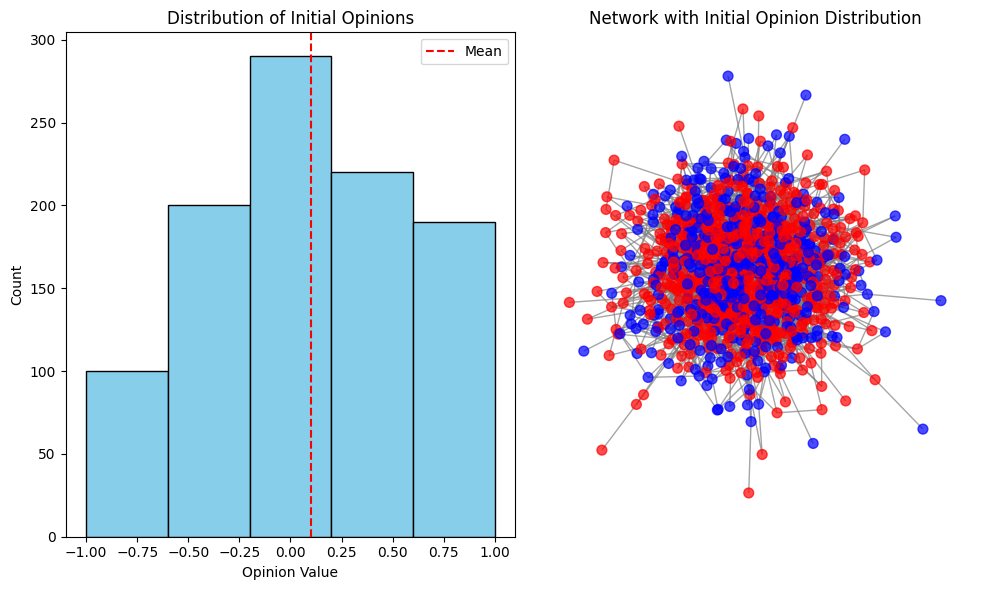

/Users/lexie/Documents/code/amlds/models/threshold_degroot.py:80: RuntimeWarning: divide by zero encountered in matmul
  self.opinions = self.normalized_adj_matrix @ self.opinions
/Users/lexie/Documents/code/amlds/models/threshold_degroot.py:80: RuntimeWarning: overflow encountered in matmul
  self.opinions = self.normalized_adj_matrix @ self.opinions
/Users/lexie/Documents/code/amlds/models/threshold_degroot.py:80: RuntimeWarning: invalid value encountered in matmul
  self.opinions = self.normalized_adj_matrix @ self.opinions


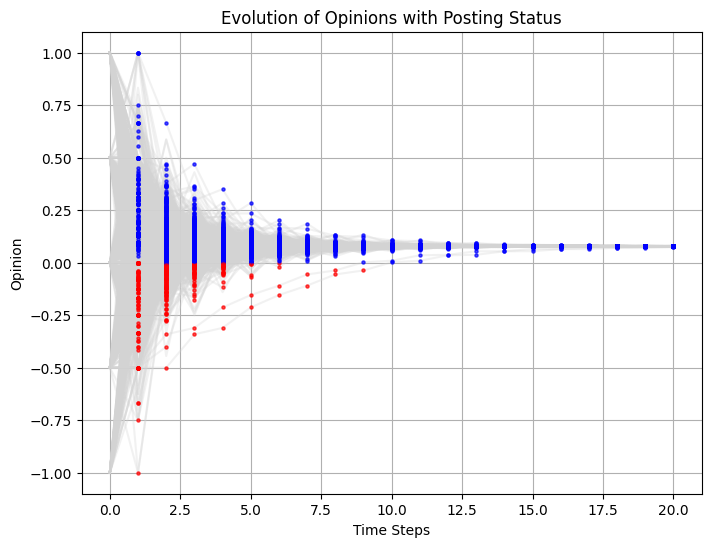

/Users/lexie/Documents/code/amlds/models/threshold_degroot.py:210: RuntimeWarning: invalid value encountered in scalar divide
  pos_to_neg_ratio = positive_posts / negative_posts
/Users/lexie/Documents/code/amlds/models/threshold_degroot.py:211: RuntimeWarning: invalid value encountered in scalar divide
  proportion_positive = positive_posts / (positive_posts + negative_posts)
/Users/lexie/Documents/code/amlds/models/threshold_degroot.py:210: RuntimeWarning: divide by zero encountered in scalar divide
  pos_to_neg_ratio = positive_posts / negative_posts


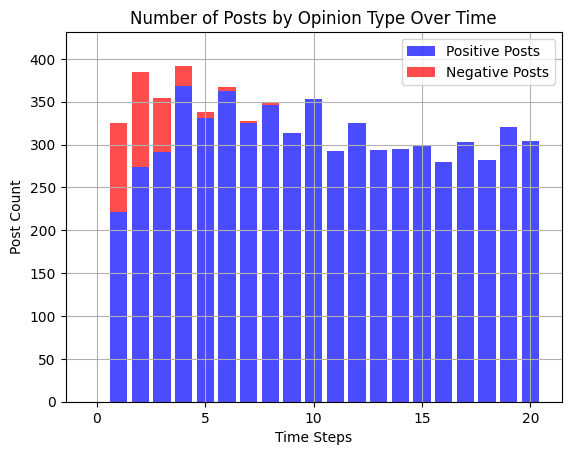

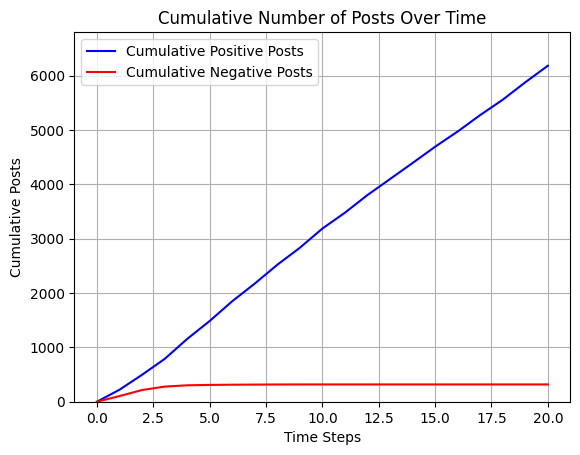

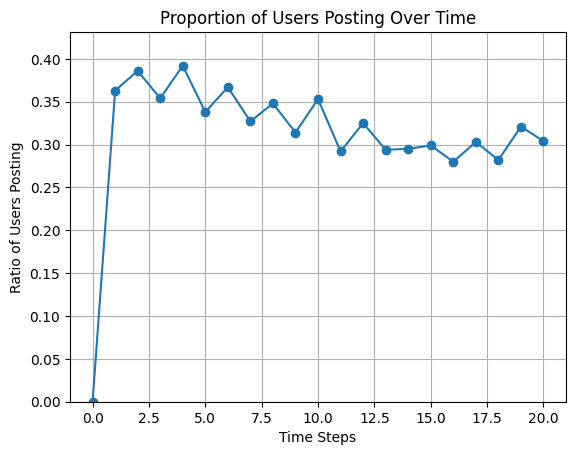

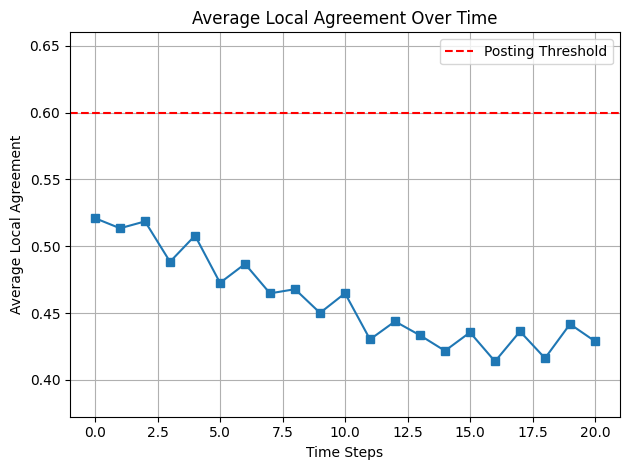

EXPERIMENT STATS:
Total posts: 6902
Positive posts: 6254 (0.91)
Negative posts: 471 (0.07)
Overall pos/neg ratio: 13.28
Overall proportion of positive posts: 0.93
Variance in proportion of positive posts over time: 0.0096

Final opinion range: 0.0062
Final opinion variance: 0.0000
Final opinion std dev: 0.0002
Final average local agreement: 0.4289
Final local agreement variance: 0.1019
Second largest eigenvalue: 0.7599


In [25]:
model, cumulative_pos_to_neg_ratio, proportion_positive_var, average_local_agreement, second_eigenvalue = run_experiment(
    graph=G,
    threshold=0.6,
    steps=20,
    visualize=True
)

## Get statistics

## Create Linear and Exponential Edge Functions

In [45]:
def generate_exponential_edges(n_buckets=7, A=100, r=0.5):
    return [max(1, int(A * r**i)) for i in range(n_buckets)]

def generate_linear_edges(n_buckets=7, start=100, end=1):
    step = (start - end) / (n_buckets - 1)
    return [max(1, int(start - i * step)) for i in range(n_buckets)]


## Testing Linear Distribution of Edges

From the top edges having 100 connections to 500

In [ ]:
buckets = ['High', 'Medium', 'Low', 'Very High', 'Very Low', 'Moderate', 'Extreme']
counts = [1, 6, 5, 17, 72, 318, 581]

start_ends = [
    (100, 1), (200, 1), (300, 1), (400, 1), (500, 1),
    (600, 1), (700, 1), (800, 1), (900, 1), (1000, 1)
]
results = []

for start, end in start_ends:
    for run in range(5):
        print('-----------------------------------------------')
        print(f"Run {run + 1} for start {start} and end {end}:")
        
        linear_edges = generate_linear_edges(n_buckets=len(buckets), start=start, end=end)

        G = create_influencer_graph(
            n_nodes=1000,
            view_buckets=buckets,
            bucket_counts=counts,
            bucket_edges=linear_edges,
            seed= 43 + run
        )

        model = DeGrootThresholdModel(G, local_agreement_threshold=0.6)
        model.initialize_opinions_manual(
            initial_opinions=ispal_op,
            proportions=ispal_prop
        )

        model, cumulative_pos_to_neg_ratio, proportion_positive_var, average_local_agreement, second_eigenvalue = run_experiment(
            graph=G,
            threshold=0.6,
            steps=50,
            visualize=False
        )

        results.append({
            'run': run + 1,
            'start_edge': start,
            'end_edge': end,
            'bucket_edges': linear_edges,
            'cumulative_pos_to_neg_ratio': cumulative_pos_to_neg_ratio,
            'proportion_positive_var': proportion_positive_var,
            'local_agreement': average_local_agreement,
            'second_eigenvalue': second_eigenvalue
        })

results_df = pd.DataFrame(results)
summary = results_df.groupby(['start_edge', 'end_edge']).agg({
'cumulative_pos_to_neg_ratio': ['mean', 'std'],
'proportion_positive_var': ['mean', 'std'],
'local_agreement': ['mean', 'std'],
'second_eigenvalue': ['mean', 'std']
}).reset_index()
summary.columns = ['_'.join(col).strip('_') for col in summary.columns.values]
print(summary)


-----------------------------------------------
Run 1 for start 100 and end 1:
Initial opinion distribution:
  Positive opinions: 41.00%
  Negative opinions: 30.00%
  Neutral opinions: 29.00%
  Positive-to-negative ratio: 1.37
  Initial proportion of opinions on positive side: 57.75%
Initial opinion distribution:
  Positive opinions: 41.00%
  Negative opinions: 30.00%
  Neutral opinions: 29.00%
  Positive-to-negative ratio: 1.37
  Initial proportion of opinions on positive side: 57.75%
EXPERIMENT STATS:
Total posts: 19100
Positive posts: 18748 (0.98)
Negative posts: 201 (0.01)
Overall pos/neg ratio: 93.27
Overall proportion of positive posts: 0.99
Variance in proportion of positive posts over time: 0.0010

Final opinion range: 0.0000
Final opinion variance: 0.0000
Final opinion std dev: 0.0000
Final average local agreement: 0.9084
Final local agreement variance: 0.0357


/Users/lexie/Documents/code/amlds/models/threshold_degroot.py:80: RuntimeWarning: divide by zero encountered in matmul
  self.opinions = self.normalized_adj_matrix @ self.opinions
/Users/lexie/Documents/code/amlds/models/threshold_degroot.py:80: RuntimeWarning: overflow encountered in matmul
  self.opinions = self.normalized_adj_matrix @ self.opinions
/Users/lexie/Documents/code/amlds/models/threshold_degroot.py:80: RuntimeWarning: invalid value encountered in matmul
  self.opinions = self.normalized_adj_matrix @ self.opinions
/Users/lexie/Documents/code/amlds/models/threshold_degroot.py:210: RuntimeWarning: invalid value encountered in scalar divide
  pos_to_neg_ratio = positive_posts / negative_posts
/Users/lexie/Documents/code/amlds/models/threshold_degroot.py:211: RuntimeWarning: invalid value encountered in scalar divide
  proportion_positive = positive_posts / (positive_posts + negative_posts)
/Users/lexie/Documents/code/amlds/models/threshold_degroot.py:210: RuntimeWarning: divi

Second largest eigenvalue: 0.4466
-----------------------------------------------
Run 2 for start 100 and end 1:
Initial opinion distribution:
  Positive opinions: 41.00%
  Negative opinions: 30.00%
  Neutral opinions: 29.00%
  Positive-to-negative ratio: 1.37
  Initial proportion of opinions on positive side: 57.75%
Initial opinion distribution:
  Positive opinions: 41.00%
  Negative opinions: 30.00%
  Neutral opinions: 29.00%
  Positive-to-negative ratio: 1.37
  Initial proportion of opinions on positive side: 57.75%
EXPERIMENT STATS:
Total posts: 21090
Positive posts: 20704 (0.98)
Negative posts: 239 (0.01)
Overall pos/neg ratio: 86.63
Overall proportion of positive posts: 0.99
Variance in proportion of positive posts over time: 0.0021

Final opinion range: 0.0000
Final opinion variance: 0.0000
Final opinion std dev: 0.0000
Final average local agreement: 0.9617
Final local agreement variance: 0.0180
Second largest eigenvalue: 0.4374
-----------------------------------------------
Ru

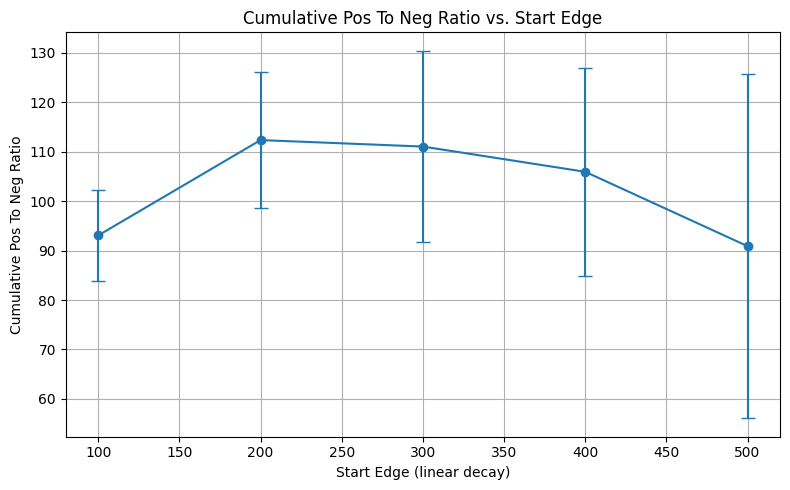

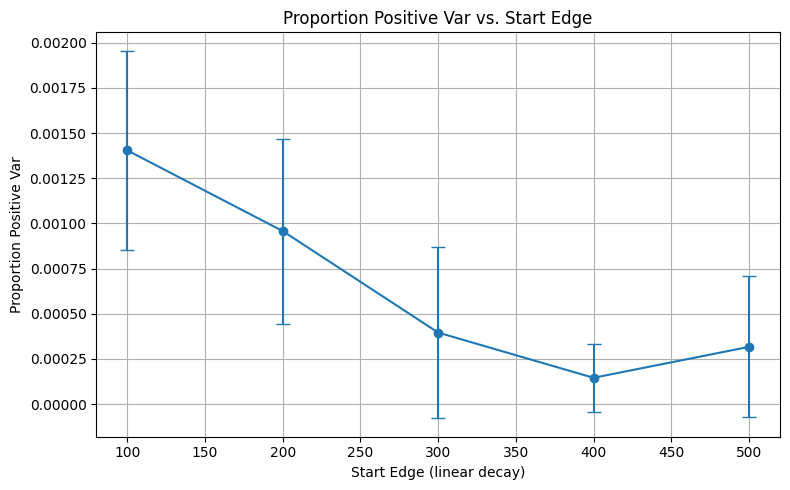

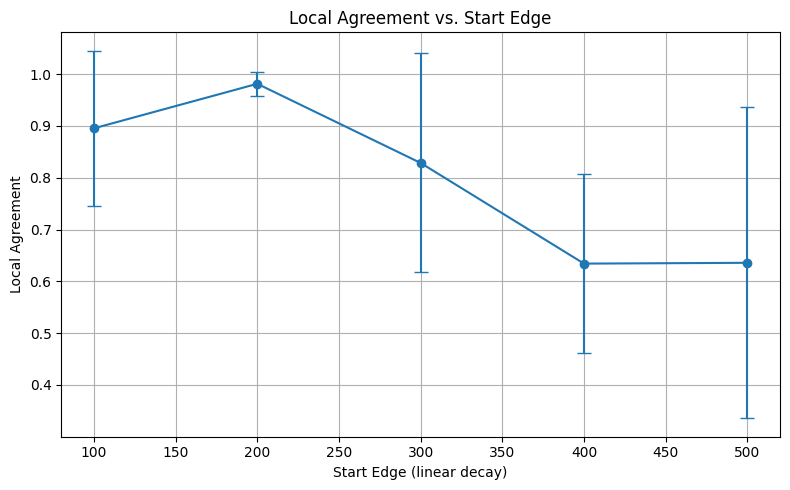

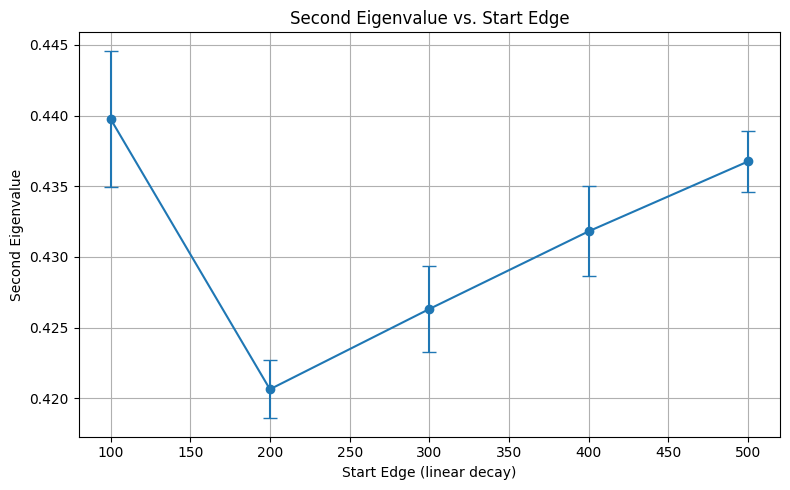

In [57]:
# Pick metrics you want to track
metrics = [
    'cumulative_pos_to_neg_ratio',
    'proportion_positive_var',
    'local_agreement',
    'second_eigenvalue'
]

# Loop through each metric and plot the mean ± std across runs
for metric in metrics:
    plt.figure(figsize=(8, 5))
    
    grouped = results_df.groupby('start_edge')[metric]
    means = grouped.mean()
    stds = grouped.std()
    
    plt.errorbar(means.index, means.values, yerr=stds.values, fmt='-o', capsize=5)
    plt.title(f'{metric.replace("_", " ").title()} vs. Start Edge')
    plt.xlabel('Start Edge (linear decay)')
    plt.ylabel(metric.replace("_", " ").title())
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/var/folders/g7/wjgrv_fd1kl33kczgrqqngph0000gn/T/ipykernel_39201/3055889495.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


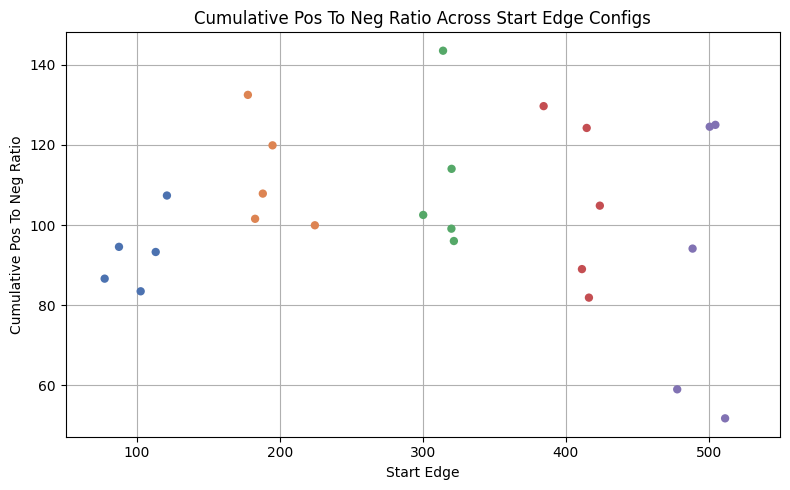

/var/folders/g7/wjgrv_fd1kl33kczgrqqngph0000gn/T/ipykernel_39201/3055889495.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


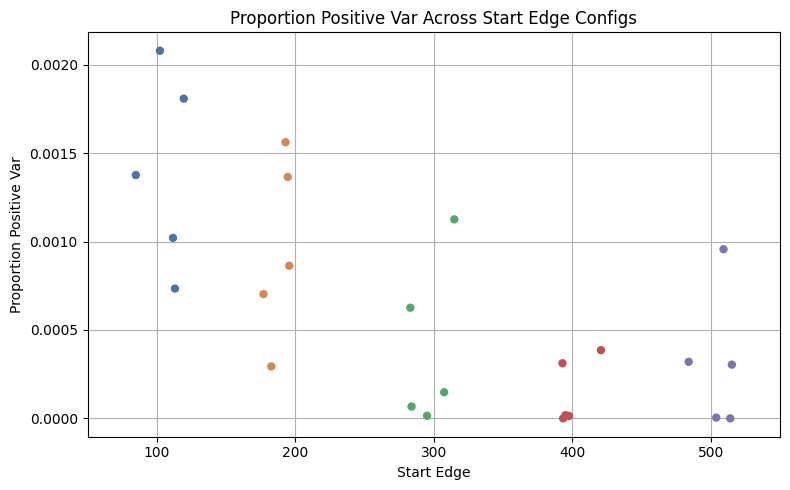

/var/folders/g7/wjgrv_fd1kl33kczgrqqngph0000gn/T/ipykernel_39201/3055889495.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


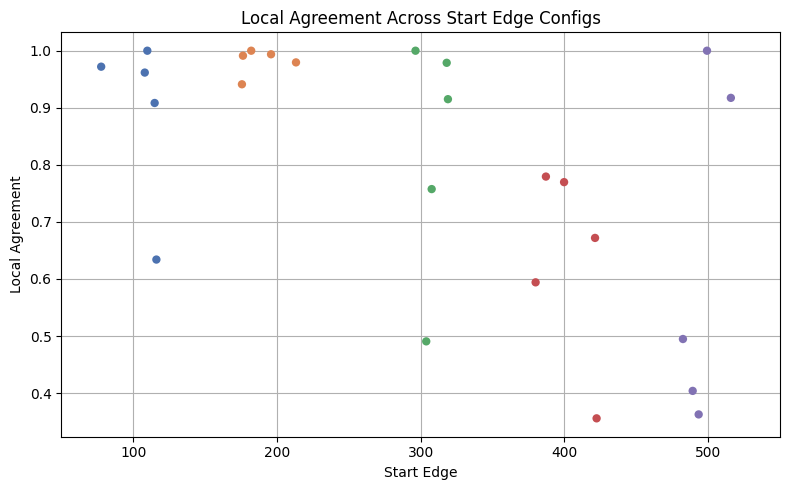

/var/folders/g7/wjgrv_fd1kl33kczgrqqngph0000gn/T/ipykernel_39201/3055889495.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


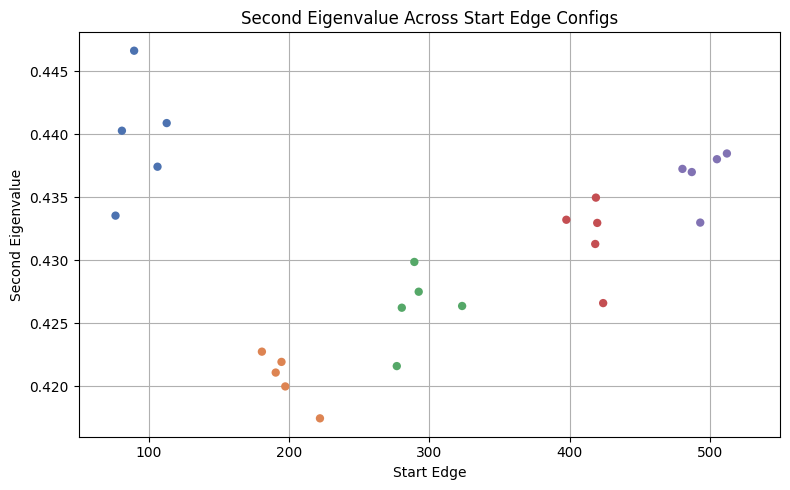

In [61]:

metrics = [
    'cumulative_pos_to_neg_ratio',
    'proportion_positive_var',
    'local_agreement',
    'second_eigenvalue'
]

for metric in metrics:
    plt.figure(figsize=(8, 5))
    sns.stripplot(
        x='start_edge',
        y=metric,
        data=results_df,
        jitter=0.25,
        size=6,
        palette='deep'
    )
    plt.title(f'{metric.replace("_", " ").title()} Across Start Edge Configs')
    plt.xlabel('Start Edge')
    plt.ylabel(metric.replace("_", " ").title())
    plt.grid(True)
    plt.tight_layout()
    plt.show()